### Import Lib

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Sample Data

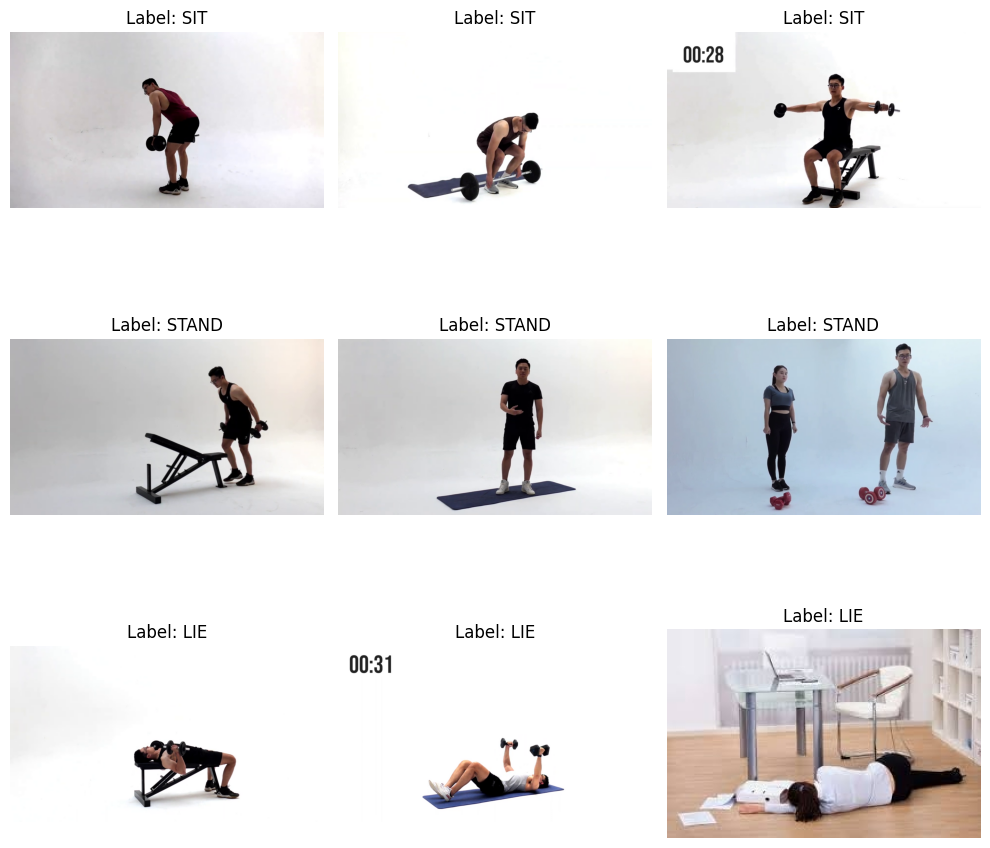

In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục gốc chứa dữ liệu
data_dir = 'C:/Users/Admin/Documents/Project/Dectect_Stand_Sit_Lie/Posture_classification/data-sit-stand-lie'

# Các lớp (thư mục con) cần lấy ảnh
wanted_classes = ['SIT', 'STAND', 'LIE']
num_samples_to_show = 9  # Số lượng ảnh cần hiển thị

# Danh sách lưu các ảnh gốc và nhãn
original_images = []
original_labels = []

# Lấy ảnh ngẫu nhiên từ mỗi thư mục nhãn
for class_name in wanted_classes:
    class_path = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_path)
    
    # Chọn ngẫu nhiên một vài ảnh từ thư mục
    selected_files = random.sample(image_files, num_samples_to_show // len(wanted_classes))
    
    for file_name in selected_files:
        img_path = os.path.join(class_path, file_name)
        img = Image.open(img_path)
        original_images.append(img)
        original_labels.append(class_name)

# Hiển thị các ảnh gốc
plt.figure(figsize=(10, 10))
for i in range(len(original_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(f"Label: {original_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Data Processing

In [3]:
import tensorflow as tf
import numpy as np
import os

# Đường dẫn tới thư mục chứa dữ liệu
data_dir = 'C:/Users/Admin/Documents/Project/Dectect_Stand_Sit_Lie/Posture_classification/data-sit-stand-lie'
img_height, img_width = 64, 64
batch_size = 5000  # Giảm batch_size để load dữ liệu một cách hiệu quả hơn

# Chỉ định các thư mục nhãn mà chúng ta muốn lấy dữ liệu
wanted_classes = ['SIT', 'STAND', 'LIE']


# Sử dụng ImageDataGenerator để chuẩn bị dữ liệu đầu vào
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

# Tạo tập dữ liệu chỉ với các thư mục mong muốn, chuyển ảnh về grayscale
data_flow = data_gen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',  # Chuyển ảnh về grayscale
    class_mode='sparse',     # Nhãn dưới dạng số nguyên
    shuffle=True,
    classes=wanted_classes   # Chỉ lấy dữ liệu từ các thư mục mong muốn
)


# Lấy toàn bộ dữ liệu và nhãn từ data_flow
images, labels = data_flow.next()

# Xác định số mẫu nhỏ nhất trong mỗi lớp để lấy mẫu cân bằng
min_samples_per_class = min(np.bincount(labels.astype(int)))

# Lấy chỉ số của các mẫu để tạo tập dữ liệu cân bằng
balanced_indices = []
for class_label in np.unique(labels):
    indices = np.where(labels == class_label)[0]
    balanced_indices.extend(indices[:min_samples_per_class])

# Tạo tập dữ liệu cân bằng dựa trên các chỉ số đã chọn
images_balanced = images[balanced_indices]
labels_balanced = labels[balanced_indices]

# Chia dữ liệu thành tập huấn luyện và tập kiểm định (validation) với `stratify` để giữ tỷ lệ
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images_balanced, labels_balanced, test_size=0.2, random_state=42, stratify=labels_balanced
)

# Chia tiếp thành tập validation và tập kiểm tra (test)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Đảm bảo nhãn có dạng (samples, 1)
train_labels = train_labels.reshape(-1, 1)
val_labels = val_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

# In ra kích thước để xác nhận
print(f"Train Images Shape:       {train_images.shape}")
print(f"Train Labels Shape:       {train_labels.shape}")
print(f"Validation Images Shape:  {val_images.shape}")
print(f"Validation Labels Shape:  {val_labels.shape}")
print(f"Test Images Shape:        {test_images.shape}")
print(f"Test Labels Shape:        {test_labels.shape}")



Found 3434 images belonging to 3 classes.
Train Images Shape:       (1896, 64, 64, 1)
Train Labels Shape:       (1896, 1)
Validation Images Shape:  (237, 64, 64, 1)
Validation Labels Shape:  (237, 1)
Test Images Shape:        (237, 64, 64, 1)
Test Labels Shape:        (237, 1)


### Check Balance Data

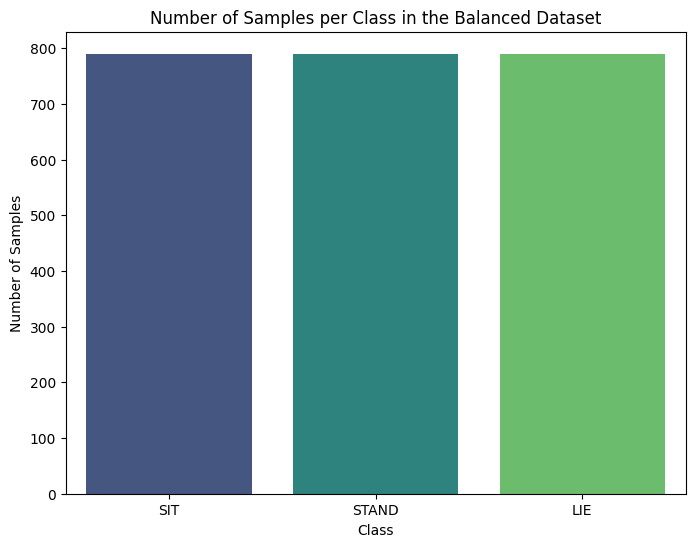

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Đếm số lượng mẫu của mỗi lớp
class_counts = Counter(labels_balanced)

# Tạo danh sách nhãn và số lượng mẫu của từng lớp
class_labels = [wanted_classes[int(cls)] for cls in class_counts.keys()]
class_values = list(class_counts.values())

# Hiển thị biểu đồ số lượng data mỗi class
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_values, palette='viridis')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Class in the Balanced Dataset")
plt.show()


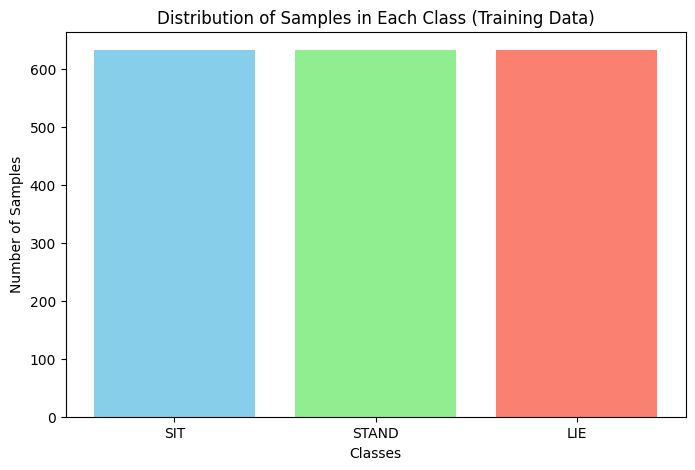

In [5]:
# Đếm số lượng mẫu trong mỗi lớp trong tập dữ liệu huấn luyện
unique, counts = np.unique(train_labels, return_counts=True)
class_counts = dict(zip(unique, counts))

# Tên các lớp
class_names = ['SIT', 'STAND', 'LIE']

# Xây dựng danh sách số lượng mẫu trong mỗi lớp
class_counts_list = [class_counts.get(i, 0) for i in range(len(class_names))]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts_list, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Samples in Each Class (Training Data)")
plt.show()


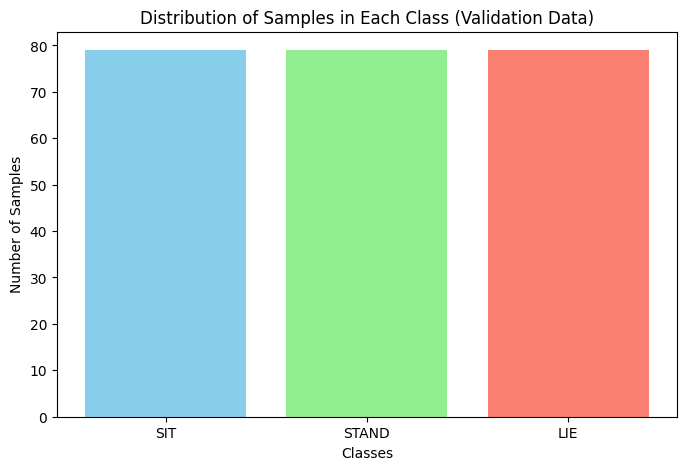

In [6]:
# Đếm số lượng mẫu trong mỗi lớp trong tập dữ liệu huấn luyện
unique, counts = np.unique(val_labels, return_counts=True)
class_counts = dict(zip(unique, counts))

# Tên các lớp
class_names = ['SIT', 'STAND', 'LIE']

# Xây dựng danh sách số lượng mẫu trong mỗi lớp
class_counts_list = [class_counts.get(i, 0) for i in range(len(class_names))]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts_list, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Samples in Each Class (Validation Data)")
plt.show()


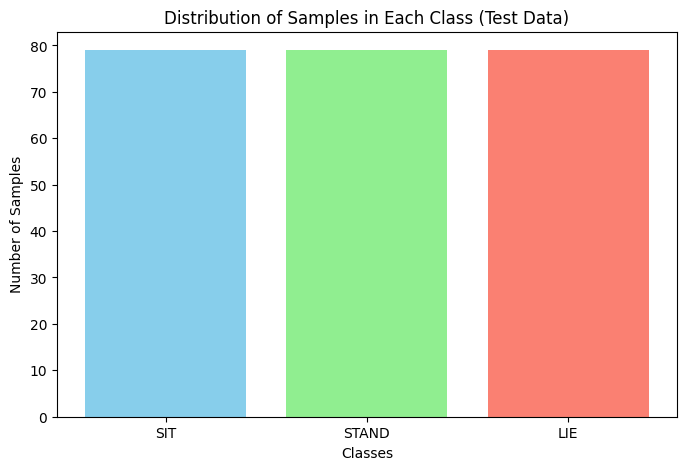

In [7]:
# Đếm số lượng mẫu trong mỗi lớp trong tập dữ liệu huấn luyện
unique, counts = np.unique(test_labels, return_counts=True)
class_counts = dict(zip(unique, counts))

# Tên các lớp
class_names = ['SIT', 'STAND', 'LIE']

# Xây dựng danh sách số lượng mẫu trong mỗi lớp
class_counts_list = [class_counts.get(i, 0) for i in range(len(class_names))]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts_list, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Samples in Each Class (Test Data)")
plt.show()


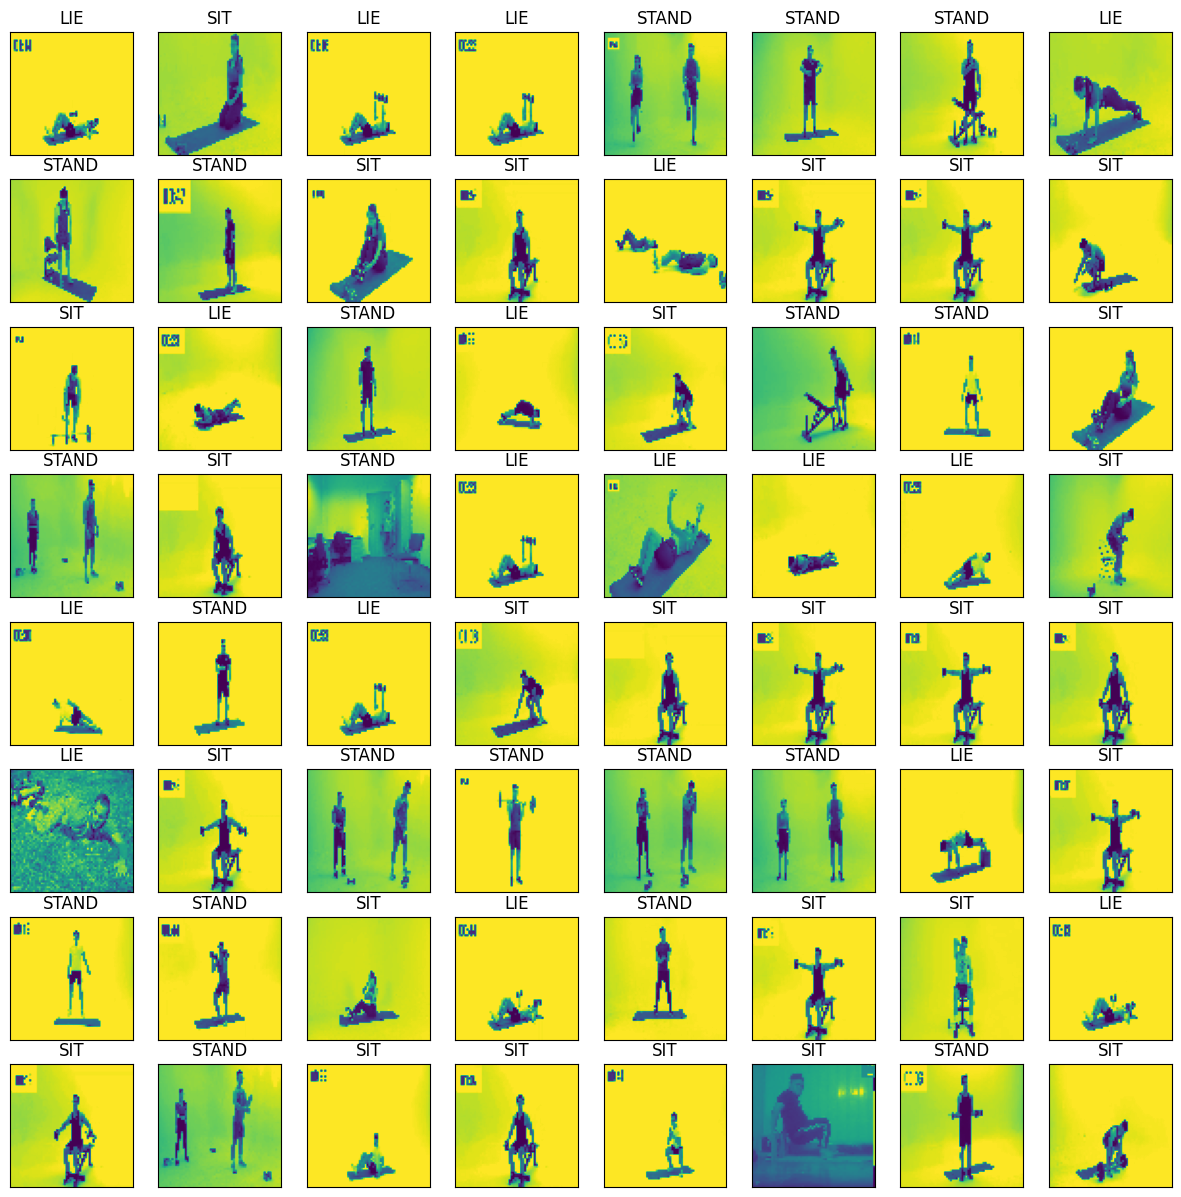

In [8]:
import matplotlib.pyplot as plt

# Tên các lớp tư thế
class_names = ['SIT', 'STAND', 'LIE']

# Tạo một figure mới với kích thước 15x15
plt.figure(figsize=(15, 15))

# Hiển thị 64 ảnh đầu tiên trong tập huấn luyện
for i in range(64):
    # Tạo subplot cho mỗi ảnh
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Hiển thị ảnh
    plt.imshow(train_images[i])
    
    # Đặt nhãn là tiêu đề
    plt.title(class_names[int(train_labels[i][0])], fontsize=12)

# Hiển thị figure
plt.show()


In [9]:
import numpy as np

# Chuyển đổi kiểu dữ liệu pixel sang float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
val_images = val_images.astype('float32')

# Tính toán giá trị trung bình và độ lệch chuẩn của ảnh huấn luyện
mean = np.mean(train_images)
std = np.std(train_images)

# Chuẩn hóa dữ liệu (z-score normalization)
# Giá trị nhỏ 1e-7 được thêm vào để tránh chia cho 0
train_images = (train_images - mean) / (std + 1e-7)
test_images = (test_images - mean) / (std + 1e-7)
val_images = (val_images - mean) / (std + 1e-7)


In [10]:
# In ra kích thước để xác nhận
print(f"Train Images Shape:       {train_images.shape}")
print(f"Train Labels Shape:       {train_labels.shape}")
print(f"Validation Images Shape:  {val_images.shape}")
print(f"Validation Labels Shape:  {val_labels.shape}")
print(f"Test Images Shape:        {test_images.shape}")
print(f"Test Labels Shape:        {test_labels.shape}")

Train Images Shape:       (1896, 64, 64, 1)
Train Labels Shape:       (1896, 1)
Validation Images Shape:  (237, 64, 64, 1)
Validation Labels Shape:  (237, 1)
Test Images Shape:        (237, 64, 64, 1)
Test Labels Shape:        (237, 1)


In [11]:
# Flatten dữ liệu hình ảnh
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# In lại kích thước sau khi flatten để xác nhận
print(f"Flattened Train Images Shape: {train_images_flat.shape}")
print(f"Flattened Validation Images Shape: {val_images_flat.shape}")
print(f"Flattened Test Images Shape: {test_images_flat.shape}")


Flattened Train Images Shape: (1896, 4096)
Flattened Validation Images Shape: (237, 4096)
Flattened Test Images Shape: (237, 4096)


### Modeling

In [12]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")


# Khởi tạo dictionary để lưu kết quả
results = {
    "Model": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": [],
    "Inference Time (ms)": [],
    "Number of Parameters (M)": []
}

# List các mô hình với các tham số tùy chỉnh
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs'),
    "SVM": SVC(kernel='linear', C=1.0),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, learning_rate_init=0.001),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Hàm tính số lượng tham số của từng model (ước lượng)
def get_model_params(model):
    if hasattr(model, 'coef_'):
        return sum([coef.size for coef in model.coef_]) / 1e6  # Chuyển đổi thành triệu
    elif hasattr(model, 'estimators_'):
        return len(model.estimators_) * len(train_images_flat[0]) / 1e6  # Ước lượng cho RF
    elif isinstance(model, MLPClassifier):
        return sum(layer.size for layer in model.coefs_) / 1e6
    return 0  # Giá trị mặc định nếu không tính được



Đang huấn luyện mô hình: Logistic Regression

Luấn luyện mô hình đã xong: Logistic Regression
Confusion Matrix:
[[79  0  0]
 [ 2 75  2]
 [ 4  1 74]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        79
         1.0       0.99      0.95      0.97        79
         2.0       0.97      0.94      0.95        79

    accuracy                           0.96       237
   macro avg       0.96      0.96      0.96       237
weighted avg       0.96      0.96      0.96       237



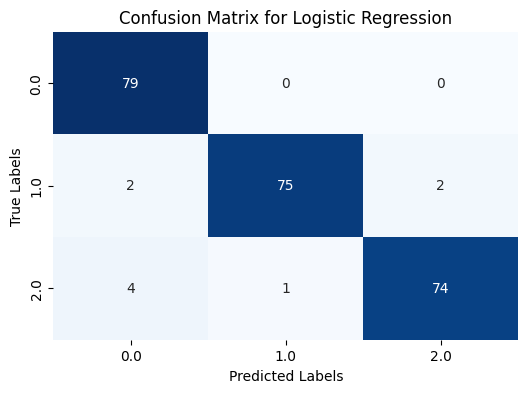


Đang huấn luyện mô hình: SVM

Luấn luyện mô hình đã xong: SVM
Confusion Matrix:
[[78  1  0]
 [ 5 73  1]
 [ 6  0 73]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93        79
         1.0       0.99      0.92      0.95        79
         2.0       0.99      0.92      0.95        79

    accuracy                           0.95       237
   macro avg       0.95      0.95      0.95       237
weighted avg       0.95      0.95      0.95       237



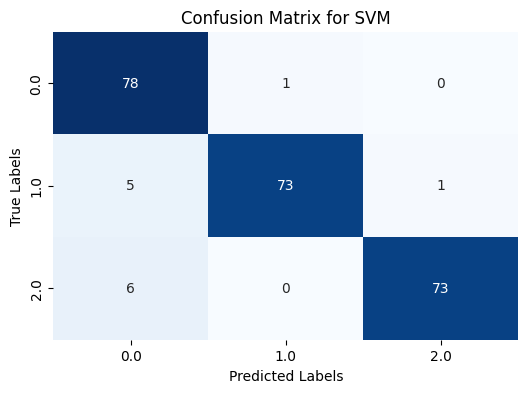


Đang huấn luyện mô hình: MLP

Luấn luyện mô hình đã xong: MLP
Confusion Matrix:
[[78  0  1]
 [ 2 75  2]
 [ 3  0 76]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96        79
         1.0       1.00      0.95      0.97        79
         2.0       0.96      0.96      0.96        79

    accuracy                           0.97       237
   macro avg       0.97      0.97      0.97       237
weighted avg       0.97      0.97      0.97       237



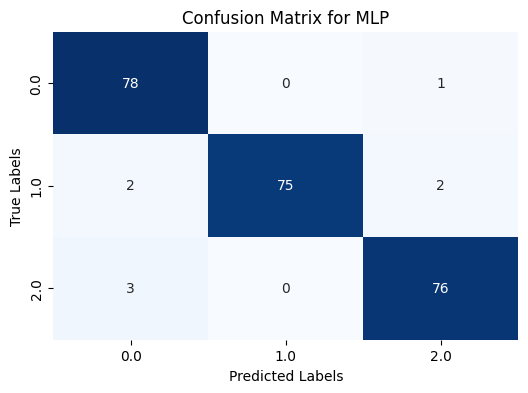


Đang huấn luyện mô hình: Random Forest

Luấn luyện mô hình đã xong: Random Forest
Confusion Matrix:
[[78  0  1]
 [ 3 75  1]
 [ 3  0 76]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96        79
         1.0       1.00      0.95      0.97        79
         2.0       0.97      0.96      0.97        79

    accuracy                           0.97       237
   macro avg       0.97      0.97      0.97       237
weighted avg       0.97      0.97      0.97       237



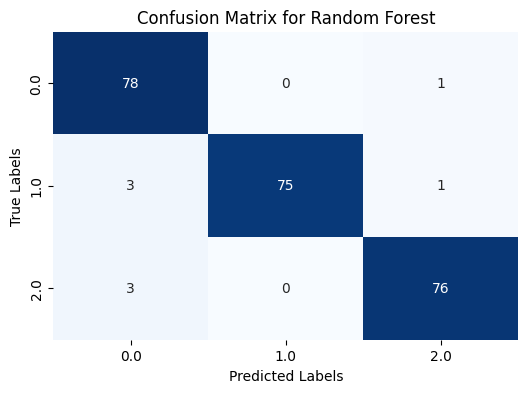


Đang huấn luyện mô hình: KNN

Luấn luyện mô hình đã xong: KNN
Confusion Matrix:
[[75  1  3]
 [ 3 74  2]
 [ 1  1 77]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        79
         1.0       0.97      0.94      0.95        79
         2.0       0.94      0.97      0.96        79

    accuracy                           0.95       237
   macro avg       0.95      0.95      0.95       237
weighted avg       0.95      0.95      0.95       237



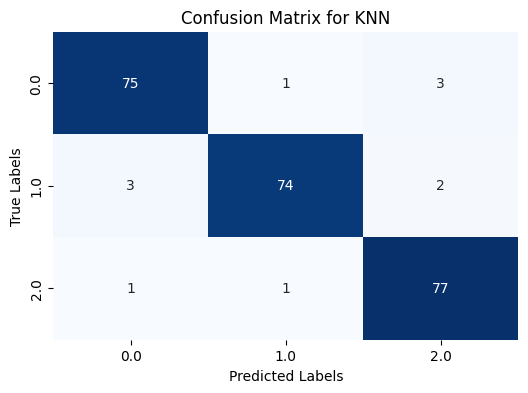

In [13]:
# Huấn luyện và đánh giá từng model
for model_name, model in models.items():
    print(f"\nĐang huấn luyện mô hình: {model_name}")
    
    # Bắt đầu đo thời gian huấn luyện
    start_time = time.time()
    model.fit(train_images_flat, train_labels.ravel())
    inference_time = (time.time() - start_time) / len(test_images_flat) * 1000  # Tính thời gian inference (ms/mẫu)

    print(f"\nLuấn luyện mô hình đã xong: {model_name}")

    # Dự đoán và tính các metric
    predictions = model.predict(test_images_flat)
    f1 = f1_score(test_labels, predictions, average='weighted')
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    
    # In Confusion Matrix và Classification Report
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, predictions))
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions))
    
    # Vẽ Confusion Matrix
    conf_matrix = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
    # Tính số lượng tham số của model
    num_params = get_model_params(model)
    
    # Lưu kết quả vào dictionary
    results["Model"].append(model_name)
    results["F1 Score"].append(f1)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["Inference Time (ms)"].append(inference_time)
    results["Number of Parameters (M)"].append(num_params)

In [14]:
# Chuyển kết quả thành DataFrame và lưu vào file CSV
results_df = pd.DataFrame(results)
results_df.to_csv("model_metrics.csv", index=False)
print("Model metrics saved to model_metrics.csv")

Model metrics saved to model_metrics.csv


### Result

In [15]:
results_df

,Model,F1 Score,Precision,Recall,Inference Time (ms),Number of Parameters (M)
0,Logistic Regression,0.961998,0.963313,0.962025,59.350530,0.012288
1,SVM,0.945689,0.949792,0.945148,15.075162,0.012288
2,MLP,0.966338,0.967261,0.966245,36.499937,0.532672
3,Random Forest,0.966411,0.967643,0.966245,13.736300,0.409600
4,KNN,0.953576,0.954025,0.953586,0.020880,0.000000


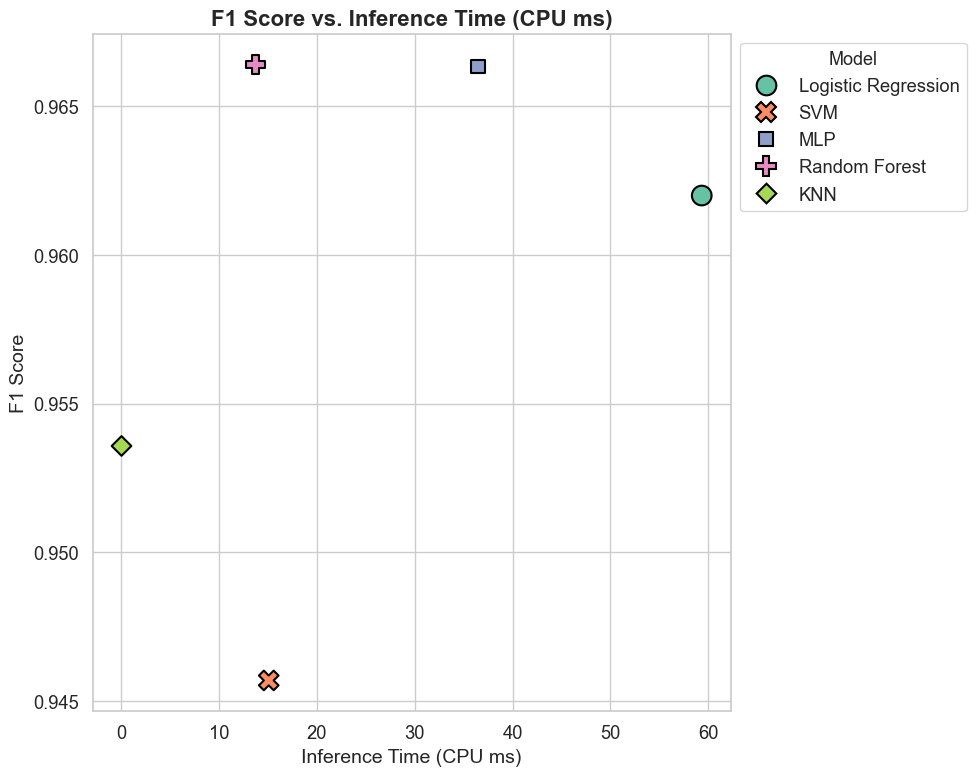

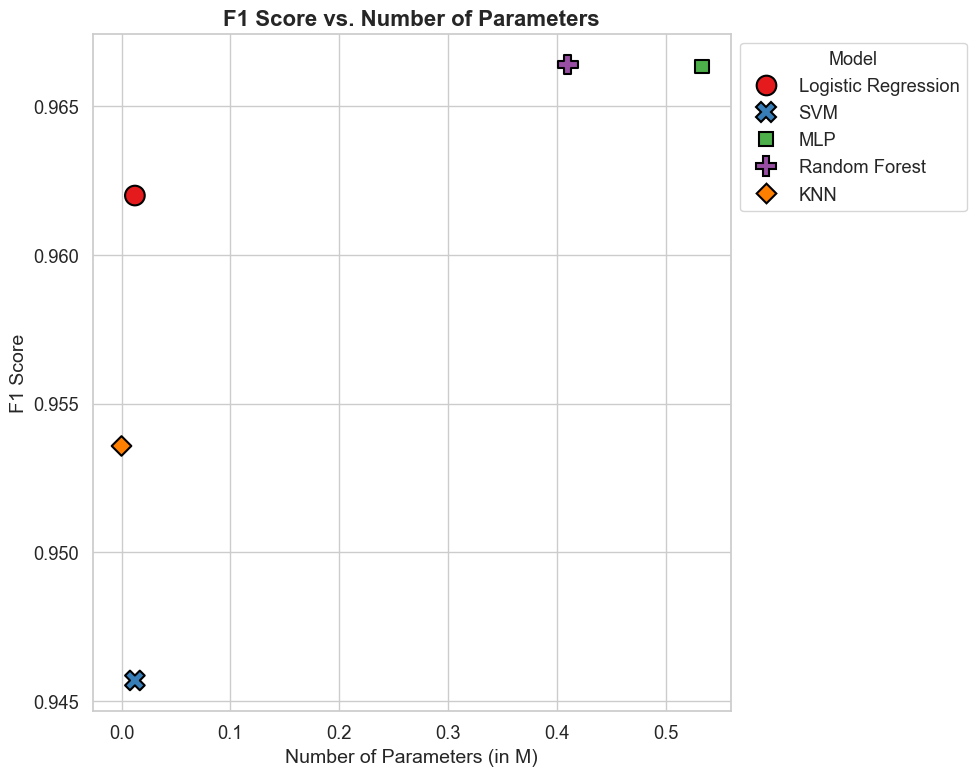

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sử dụng một style đẹp hơn từ seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Biểu đồ F1 Score vs. Thời gian inference (CPU ms)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="Inference Time (ms)", y="F1 Score", hue="Model", style="Model", data=results_df,
    s=200, edgecolor='black', linewidth=1.5, palette="Set2"
)
plt.title("F1 Score vs. Inference Time (CPU ms)", fontsize=16, fontweight='bold')
plt.xlabel("Inference Time (CPU ms)", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.legend(title="Model", title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Để sắp xếp đẹp hơn khi có nhiều thành phần
plt.show()

# Biểu đồ F1 Score vs. Số lượng tham số
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="Number of Parameters (M)", y="F1 Score", hue="Model", style="Model", data=results_df,
    s=200, edgecolor='black', linewidth=1.5, palette="Set1"
)
plt.title("F1 Score vs. Number of Parameters", fontsize=16, fontweight='bold')
plt.xlabel("Number of Parameters (in M)", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.legend(title="Model", title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


### Test Model with Online Image


In [17]:
# Tải ảnh mẫu từ URL
url = "https://file.hstatic.net/200000503583/file/tao-dang-chup-anh-dung-nu__2__a4c57357b7e04cb7a3643a3039ab2c26.jpg"  # Đặt URL ảnh mẫu ở đây
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSrKQ71amjfrhsjQ8wWthtA1XrscmzplqM7jw&s"  # Đặt URL ảnh mẫu ở đây
# url = "https://cdn-i.vtcnews.vn/resize/th/upload/2021/01/05/batchimg3348-08173505.jpg"  # Đặt URL ảnh mẫu ở đây
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Chuyển đổi ảnh từ BGR sang RGB để hiển thị đúng màu sắc
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


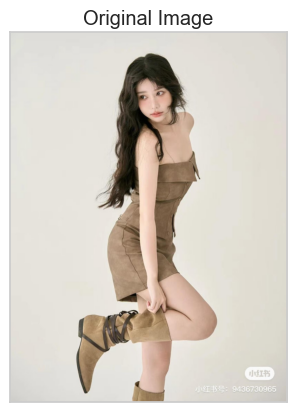

In [18]:
# Display the image
plt.imshow(image)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

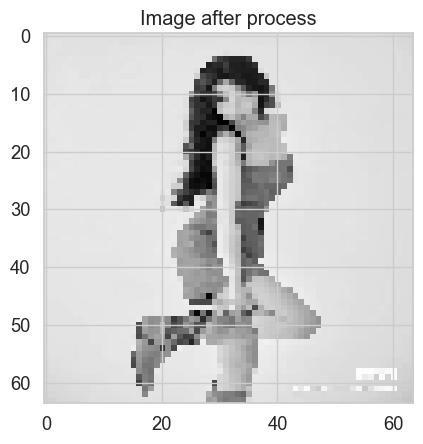

Logistic Regression Prediction: STAND
SVM Prediction: STAND
MLP Prediction: STAND
Random Forest Prediction: STAND
KNN Prediction: STAND


In [19]:
# Chuyển ảnh sang grayscale
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Resize và chuẩn hóa bằng cách chia 255
image = cv2.resize(image, (64, 64)) / 255.0

# Tính trung bình và độ lệch chuẩn của ảnh
image_mean = np.mean(image)
image_std = np.std(image)

# Chuẩn hóa ảnh theo z-score normalization
image = (image - image_mean) / (image_std + 1e-7)

# Thêm một chiều cho mô hình nhận dạng đầu vào theo batch và kênh grayscale
image = image.reshape((1, 64, 64, 1))

plt.imshow(image[0, :, :, 0], cmap='gray')  # Sử dụng cmap='gray' để hiển thị ảnh đen trắng
plt.title("Image after process")
plt.show()
# Chuẩn hóa ảnh để phù hợp với đầu vào của model
image_processed = image.reshape(1, -1) 


# Dự đoán với từng model
for model_name, model in models.items():
    # Đảm bảo model đã được huấn luyện trước đó (nếu chưa, hãy huấn luyện các model trước)
    try:
        prediction = model.predict(image_processed)
        label = wanted_classes[int(prediction[0])]
        print(f"{model_name} Prediction: {label}")
    except Exception as e:
        print(f"{model_name} chưa được huấn luyện hoặc có lỗi: {e}")
